進入Monte Carlo的範例之後，我們知道，MC的一個主要就是會從跟環境的互動中取得經驗，再利用這個經驗來優化agent，所以我們就試著從架構環境開始，範例上會參考[dennybritz](https://github.com/dennybritz/reinforcement-learning/tree/master/MC)，再加上自己的理解說明。

從範例5.1的練習我們已經對Monte Carlo有些許的認知，如果你想試試Exploring Starts的話，我在想應該是可以在env的reset的部份加入一個參數，如果提供一個初始狀態就可以用提供的初始狀態開始模擬。

$\epsilon-$greedy讓每個action都有一些許的機會可以被選擇到，而不會每次都單純的greedy，這讓一些沒有被sample過的action有活下去的動力，我們來看一下可以怎麼設置

參考的來源作者主要是利用openai所open的gym來實作環境，這部份倒是可以看個人

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

%matplotlib inline

下面先設置一些類別需要的函數，這也是看個人的習慣

action space，要牌(0)、停牌(1)

In [2]:
action_space = [0, 1] 

牌組，1~10、J、Q、K

In [3]:
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] 

設置抽牌的函數

In [4]:
def draw_card(deck):
    """隨機從牌組中抽一張牌"""
    return np.random.choice(deck)

In [5]:
draw_card(deck)

2

In [6]:
def draw_hand(deck):
    """回傳一個牌組，也就是兩張牌"""
    return [draw_card(deck), draw_card(deck)]

In [7]:
draw_hand(deck)

[5, 4]

In [8]:
def usable_ace(hand):
    """判斷牌組內是否有用ace
    
    只要牌組內有ace(1)，然後牌組的總和小於等於21，就視為將ace做為11使用
    """
    return 1 in hand and sum(hand) + 10 <= 21

In [9]:
hand = draw_hand(deck)
print(hand, usable_ace(hand))

[10, 2] False


In [10]:
def sum_hand(hand):
    """加總牌組，過程中會判斷是否有將ace做為11使用"""
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

In [11]:
sum_hand(hand)

12

In [12]:
def is_bust(hand):
    """判斷牌組是否已經爆牌"""
    return sum(hand) > 21

In [13]:
is_bust(hand)

False

In [14]:
def score(hand):  
    """還不是很清楚設置這一個函數的用意
    
    這個函數看起來就是以牌組的總和為值回傳，前提是沒有爆牌
    """
    return 0 if is_bust(hand) else sum_hand(hand)

In [15]:
score(hand)

12

下面開始設置環境

In [16]:
class BlackjackEnv():
    """21點的模擬環境，相關書本中的內容可以參考上面說明"""
    def __init__(self, action_space, deck):
        """
        action_space: 要牌、停牌
        deck: 牌組
        """
        self.action_space = action_space
        self.deck = deck
        self.action_nums = len(self.action_space)        
        
        # 初始的時候先重置牌局
        self.reset()
        
    def get_observation(self):
        """回傳當前的觀察狀態
        
        依課本說明，回傳的為[玩家的牌組總合, 庄家的1張牌, 是否將ace視為11]
        """
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))
    
    def reset(self):
        """賽局重置
        
        重置賽局的時候我們會重新發給玩家跟庄家牌組，
        只要玩家的牌組是小於12，那就再給牌，補到12
        
        return:
            observation，[玩家的牌組總合, 庄家的1張牌, 是否將ace視為11]
        """
        self.dealer = draw_hand(self.deck)
        self.player = draw_hand(self.deck)
        
        # 玩家的牌如果小於12就直接補牌
        while sum_hand(self.player) < 12:
            self.player.append(draw_card(self.deck))
        
        return self.get_observation()
        
    def step(self, action):
        """與環境的互動
        
        每個time step根據觀測到的狀態來決定一個action，
        在執行一個action之後環境就會產生新的狀態，並計算得到的reward
        其中reward贏牌+1、和牌+0、輸牌-1
        
        如果要牌，就發一張牌，然後判斷是不是有爆，
        如果停牌，那就換庄家補牌到17以上，庄家爆牌就玩家贏
        不然就是兩個比較大小決定誰贏
        
        return:
            next observation、reward、done
        """
        assert action in self.action_space
        
        # 要牌
        if action:
            self.player.append(draw_card(self.deck))
            if is_bust(self.player):
                done = True
                reward = -1
            else:
                done = False
                reward = 0
        else: # 停牌
            done = True               
            
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.deck))            
            
            if is_bust(self.dealer):
                reward = 1
            elif sum_hand(self.player) == sum_hand(self.dealer):
                reward = 0
            elif sum_hand(self.player) < sum_hand(self.dealer): 
                reward = -1
            elif sum_hand(self.player) > sum_hand(self.dealer):
                reward = 1
        
        return self.get_observation(), reward, done
            
        
            
            

new一個環境

In [17]:
env = BlackjackEnv(action_space, deck)

In [18]:
env.get_observation()

(12, 9, False)

環境設置好了，我們先來處理Example 5.1，這個範例很簡單，單純的考慮state，所以這是一個prediction的問題

首先設置policy，根據書中所說，總之20點以前就是一直要牌

In [19]:
# def book_policy(observation):
#     """根據所觀測到的state來決定action
#     observation: 從env中得到的state
    
#     根據書中所寫，20點之前都會一直要牌
#     """
#     player_sum, _, _ = observation
#     return 0 if player_sum >= 20 else 1

這邊已經不打算使用書本上給的那個policy，而是我們自己寫一個$\epsilon-$greedy policy

In [20]:
def epsilon_greedy_policy(Q, epsilon, nA):
    """
    給定一個action-value function，根據epsilon與action的數量
    我們計算每一個action會出現的機率
    
    Args:
        Q: action-value function
        epsilon: 那微小的機率設置，0~1
        nA: action的數量
    
    Returns:
        每一個action被選擇到的機率
    
    """
    def policy_fn(observation):
        """
        首先，你就是先new一個長度是nA的numpy array，然後把epsilon的機率分給大家
        接著，再把1-epsilon的機率加回去給best action，
        也就是在看到的這個state-action pair中，其action value function最高的那個action，
        然後回傳這個機率分佈
        
        以這次的範例來說，action就是要牌跟停牌
        假設epsilon=0.5
        那先分配給兩個action [0.25, 0.25]，
        假設要牌是最佳選擇，那就把剩下的0.5加回去，變成[0.75, 0.25]
        """
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [21]:
def example5_1_epsilon_greedy(episodes, env, discount_factor=1.0, epsilon=0.1):
    """根據課本中5.1的範例設置的Monte Carlo
    
    episodes: 預計執行的賽局次數
    env: 模擬的環境
    discount_factory: 折扣因子，範例中為1
    epsilon: 多少的機率可以有機會選擇其它的action，float，0~1
    
    我們會根據Monte Carlo的特性，利用sample來模擬很多的賽局，
    再根據賽局的結果來優化action-value function
    
    我們會設置兩個defaultdict來跟蹤每一個state-action pair的reward總和與出現的次數，
    接著在每一個episode的過程中記錄這個episode的trajectory
    
    return 
        Q: state-action value function
        policy
    """
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    # V，就是value function
    # state-action pair，
    Q = defaultdict(lambda: np.zeros(env.action_nums))
    
    # 取得我們的policy
    policy = epsilon_greedy_policy(Q, epsilon, env.action_nums)
    
    for epi in range(1, episodes + 1):
        trajectory = []
        # 每個episode的開場都會重新開局這個賽局
        state = env.reset()
        # 這邊的作法是假設你在100次互動內會完成這場賽局
        # 雖然實務上很難到100次互動啦，總之爆了就結束這樣
        for i in range(100):
            # 從epsilon greedy policy中取得機率分佈
            probs = policy(state)            
            # 從得到的機率分佈中sample一個action
            action = np.random.choice(np.arange(len(probs)), p=probs)            
            # 取得與環境互動的結果
            next_state, reward, done = env.step(action)
            # 記錄軌跡
            trajectory.append((state, action, reward))
            # 如果牌局結束那停止迭代
            if done:
                break
            state = next_state
        
        # 現在我們有一個episode，也就是一場賽局的軌跡
        # 利用這個trajectory來計算value function
        # 先取出所有出現過的state-action pair，可以利用set的特性來消除重覆性資料
        state_action_in_episode = set([(tuple(x[0]), x[1]) for x in trajectory])
        for t_state, t_action in state_action_in_episode:
            sa_pair = (t_state, t_action)                              
            # 我們採用的是first visit
            # 找出這個state-action pair最早出現在這個episode的什麼地方
            # 就從這邊開始計算這個state-action的action-value
            first_occur_idx = next(i for i, x in enumerate(trajectory) 
                                   if x[0] == t_state and x[1] == t_action)            
            # 如果忘了這個公式，可以回頭看Chapter 3
            # G: expected return, x[2]: reward
            G = sum([x[2] * (discount_factor ** i) for i, x in enumerate(trajectory[first_occur_idx: ])])
            # 把這個state得到的expected return加起來
            returns_sum[sa_pair] += G
            # 加總這個state出現的次數
            returns_count[sa_pair] += 1
            Q[t_state][t_action] = returns_sum[sa_pair] / returns_count[sa_pair]
        
    return Q, policy
            

來試玩10局吧

In [22]:
env = BlackjackEnv(action_space, deck)
Q_10, policy = example5_1_epsilon_greedy(10, env)

In [23]:
Q_10

defaultdict(<function __main__.example5_1_epsilon_greedy.<locals>.<lambda>()>,
            {(12, 5, False): array([1., 0.]),
             (14, 2, False): array([-1.,  0.]),
             (21, 10, False): array([0., 0.]),
             (21, 4, True): array([1., 0.]),
             (20, 7, False): array([ 0., -1.]),
             (19, 2, False): array([1., 0.]),
             (18, 8, False): array([1., 0.]),
             (20, 6, False): array([ 0., -1.]),
             (19, 3, False): array([1., 0.]),
             (21, 2, True): array([1., 0.])})

課本中是以玩10,000與500,000來做比較，我們也試一下

In [24]:
%%time
env = BlackjackEnv(action_space, deck)
Q_10k, policy = example5_1_epsilon_greedy(10000, env)

CPU times: user 1.68 s, sys: 146 ms, total: 1.83 s
Wall time: 1.66 s


In [25]:
%%time
env = BlackjackEnv(action_space, deck)
Q_500k, policy = example5_1_epsilon_greedy(500000, env)

CPU times: user 1min 18s, sys: 709 ms, total: 1min 19s
Wall time: 1min 18s


In [26]:
Q_500k[(12,2,0)]

array([-0.30125725, -0.34482759])

In [27]:
policy((12, 2, 0))

array([0.95, 0.05])

下面我們用dennybritz所寫的繪圖函數，主要使用的是3D的模組，一些細節說明可以看Example 5.1，這邊不再重覆說明

In [28]:
def plot_value_function(V, title="Value Function"):
    """繪製value function
    
    我們的圖表會有兩張圖與三個維度：
        兩張圖分別為有沒有把ace視為11使用
        三個維度為：
        (1)玩家的牌組(因為玩家的牌預設已經是大於等於12以上，因此會從12開始)
        (2)庄家亮出的牌
        (3)該state的value
    """
    # 這邊整理的是玩家的牌與庄家的牌最小值與最大值
    # 不過個人認為，因為範例上一開始已經限定值域了，因此應該可以直接硬性設定即可        
#     min_x = min(k[0] for k in V.keys())
#     max_x = max(k[0] for k in V.keys())
#     min_y = min(k[1] for k in V.keys())
#     max_y = max(k[1] for k in V.keys())
    min_x, max_x, min_y, max_y = 12, 21, 1, 10
        
    x_range = np.arange(min_x, max_x + 1)    
    y_range = np.arange(min_y, max_y + 1)
    # np.meshgrid是一個生成座標矩陣的函數    
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    # np.apply_along_axis就是一種人如其名的函數，針對某一個軸向執行某一個函數
    # 主要是取得把ace視為11與不視為11的資料
    # 回傳的value function是一個defaultdict(float)的資料
    # 因此利用座標去詢條件，舉例來說，V[0, 0, False]，有值有值，沒有值就是0
    # 如果還不是很清楚可以看上面的分段執行的結果就不難理解這邊處理的手法
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))
    
    def plot_surface(X, Y, Z, title):
        # 定義figure的大小
        fig = plt.figure(figsize=(20, 10))
        # 增加一個3d的子圖表
        ax = fig.add_subplot(111, projection='3d')
        # rstride、cstride: 座標軸的間距大小
        # vmin, vmax: value的最大最小值，
        # cmap: 色彩配置
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        # 視角的設置
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

因為我們的Q是action-value function，所以要做一點處理

In [29]:
for state, action in Q_10.items():
    print(state, action)

(12, 5, False) [1. 0.]
(14, 2, False) [-1.  0.]
(21, 10, False) [0. 0.]
(21, 4, True) [1. 0.]
(20, 7, False) [ 0. -1.]
(19, 2, False) [1. 0.]
(18, 8, False) [1. 0.]
(20, 6, False) [ 0. -1.]
(19, 3, False) [1. 0.]
(21, 2, True) [1. 0.]


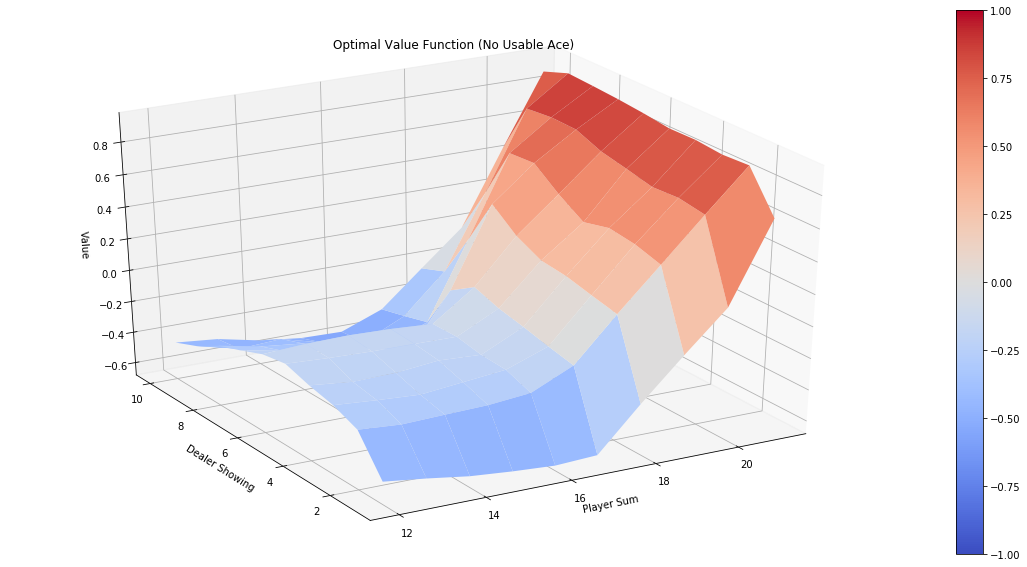

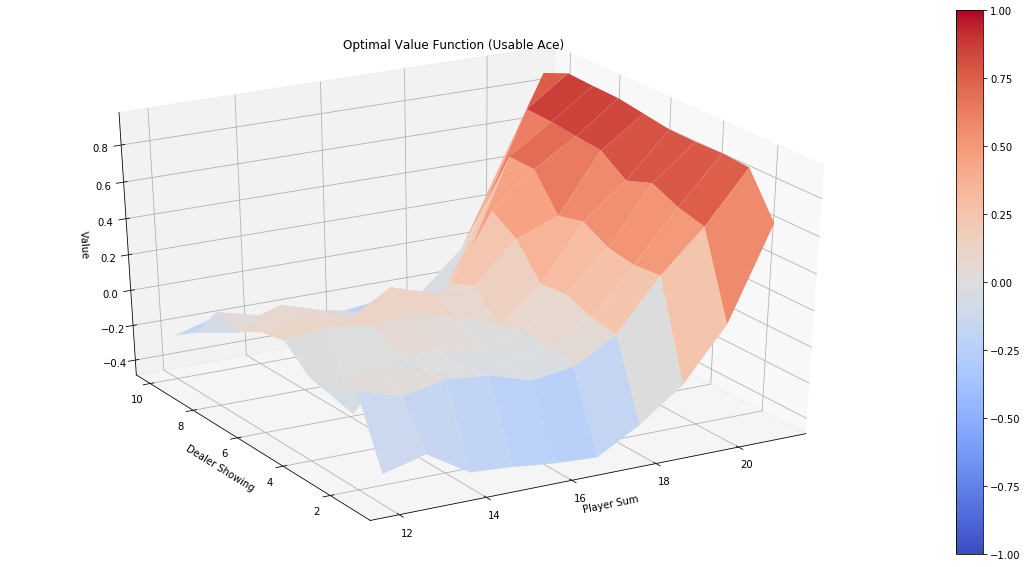

In [30]:
V = defaultdict(float)

for state, action in Q_500k.items():
    action_value = np.max(action)
    V[state] = action_value
plot_value_function(V, 'Optimal Value Function')  